# Recognizing all digits in MNIST dataset, finding best LRs
Completely using fast.ai/pytorch libraries and python classes.

In [305]:
from fastai.vision.all import *

# Preparing dataset

In [306]:
full_dataset_dir = untar_data(URLs.MNIST)

In [307]:
image_size=28*28 # np.prod(array(Image.open(Path.ls(full_dataset_dir/'training/3/')[0])).shape)

In [308]:
numbers= range(0,10)

In [309]:
def load_mnist(top_dir='testing'):
    full_dataset=[]
    labels=[]
    for number in numbers:
        path = Path.ls(full_dataset_dir/'{}/{}/'.format(top_dir,number))
        im_tensor = [ tensor(Image.open(p)) for p in path ]
        for i in range(0,len(im_tensor)): # otherwise it would simply be a list of lists
            full_dataset.append(im_tensor[i])
            labels.append(number)
    x_stack = (torch.stack(full_dataset).long()/255).view(-1,image_size)
    y_stack = tensor(labels).long() #.unsqueeze(1) # pytorch needs it in 1D tensor. dont transpose
    del full_dataset,labels
    return x_stack, y_stack    

In [310]:
train_x_stack,train_y_stack= load_mnist('training')
test_x_stack,test_y_stack= load_mnist('testing')

In [311]:
train_x_stack.shape, train_y_stack.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [312]:
test_x_stack.shape, test_y_stack.shape

(torch.Size([10000, 784]), torch.Size([10000]))

In [313]:
def make_dls(train_x_stack,train_y_stack,test_x_stack,test_y_stack,bs=256):
    train_dset = list(zip(train_x_stack,train_y_stack))
    test_dset = list(zip(test_x_stack,test_y_stack))
    dl = DataLoader(train_dset,batch_size=bs) # train in batches for each epoch
    test_dl = DataLoader(test_dset,batch_size=bs) # train in batches for each epoch
    dls = DataLoaders(dl,test_dl)
    return dls,train_dset,test_dset

# Find best learning rate manually

In [412]:
bs=256

In [413]:
rates = np.logspace(-6,0,num=15,dtype=float)
rates

array([1.00000000e-06, 2.68269580e-06, 7.19685673e-06, 1.93069773e-05,
       5.17947468e-05, 1.38949549e-04, 3.72759372e-04, 1.00000000e-03,
       2.68269580e-03, 7.19685673e-03, 1.93069773e-02, 5.17947468e-02,
       1.38949549e-01, 3.72759372e-01, 1.00000000e+00])

In [414]:
deeper_net = nn.Sequential(
                nn.Linear(image_size,200),
                nn.ReLU(),
                nn.Linear(200,20),
                #nn.LogSoftmax(dim=1),
                #nn.Linear(50,20),
                nn.ReLU(),
                nn.Linear(20,len(numbers))) # since we have 10 categories as output
loss = nn.CrossEntropyLoss() # loss for multicategories
dls,train_dset,test_dset = make_dls(train_x_stack,train_y_stack,test_x_stack,test_y_stack,bs)

In [415]:
class lr_find_manual:
    def __init__(self,model,loss,dls,lr,runs):
        self.model = model
        self.loss = loss
        self.dls = dls
        self.lr = lr
        self.runs = runs
    def train(self):
        learn = Learner(self.dls, self.model, lr = self.lr, loss_func = self.loss, metrics = accuracy)
        learn.fit(self.runs)
        accur = L(learn.recorder.values).itemgot(2)[-1]
        return accur

In [416]:
accur = []
for i in range(0,len(rates)):
    lr_f = float(rates[i])
    calc = lr_find_manual(model = deeper_net, lr = lr_f , loss = loss, dls = dls, runs = 5)
    accur.append(calc.train())    

epoch,train_loss,valid_loss,accuracy,time
0,2.295254,2.305087,0.101300,00:01
1,2.294076,2.303542,0.101300,00:01
2,2.292911,2.301966,0.101300,00:01
3,2.291759,2.300368,0.101400,00:01
4,2.290627,2.298753,0.101600,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.293030,2.294967,0.105000,00:01
1,2.289917,2.290557,0.112400,00:01
2,2.286870,2.286067,0.124600,00:01
3,2.283912,2.281542,0.133700,00:01
4,2.281018,2.276981,0.144200,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.288996,2.266776,0.173600,00:01
1,2.279876,2.254606,0.187000,00:01
2,2.271291,2.241894,0.194600,00:01
3,2.263139,2.228636,0.202600,00:01
4,2.255015,2.214801,0.210200,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.278508,2.186815,0.217600,00:01
1,2.248940,2.148060,0.248500,00:01
2,2.224038,2.106917,0.326700,00:01
3,2.200704,2.064998,0.420100,00:01
4,2.178060,2.022770,0.478800,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.271741,1.980169,0.493200,00:01
1,2.201397,1.880533,0.548800,00:01
2,2.142641,1.781188,0.586300,00:01
3,2.082346,1.683476,0.612800,00:01
4,2.019298,1.588390,0.631500,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.209774,1.612690,0.509100,00:01
1,1.926401,1.488612,0.513900,00:01
2,1.698966,1.378354,0.556100,00:01
3,1.486933,1.289340,0.615300,00:01
4,1.304532,1.217898,0.633600,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.301347,1.600886,0.485200,00:01
1,0.847179,2.093951,0.399600,00:01
2,0.774715,2.134877,0.408400,00:01
3,0.805162,2.063116,0.430700,00:01
4,0.852373,1.989070,0.462500,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.968029,2.261292,0.321300,00:01
1,0.455902,4.150149,0.286500,00:01
2,0.411659,5.227072,0.298700,00:01
3,0.416167,5.779289,0.238200,00:01
4,0.468556,5.293542,0.221000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.079099,7.140115,0.156600,00:01
1,0.594899,9.357459,0.190900,00:01
2,0.539779,7.702363,0.171400,00:01
3,0.627651,14.892805,0.117900,00:01
4,0.588108,19.026699,0.277600,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.571670,2.228969,0.163400,00:01
1,1.547348,9.713675,0.186100,00:01
2,1.343366,10.510172,0.167000,00:01
3,1.685611,10.865098,0.165200,00:01
4,1.035835,46.202942,0.107600,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.898463,2.310017,0.101600,00:01
1,2.462406,2.507334,0.097400,00:01
2,2.957685,2.400814,0.125500,00:01
3,2.693968,2.507278,0.098800,00:01
4,2.847914,3.144576,0.097400,00:01


epoch,train_loss,valid_loss,accuracy,time
0,4.614919,2.597096,0.097400,00:01
1,2.695295,2.613024,0.097400,00:01
2,2.667498,2.614744,0.097400,00:01
3,2.666432,2.614923,0.097400,00:01
4,2.666347,2.614939,0.097400,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.226451,3.425327,0.100900,00:01
1,2.728406,3.952729,0.100900,00:01
2,2.727689,3.929757,0.100900,00:01
3,2.727180,3.929497,0.100900,00:01
4,2.727154,3.929420,0.100900,00:01


epoch,train_loss,valid_loss,accuracy,time
0,4.091763,11.299392,0.100900,00:01
1,4.434493,10.067036,0.100900,00:01
2,4.471552,9.965221,0.100900,00:01
3,4.514004,9.847808,0.100900,00:01
4,4.535105,9.786109,0.100900,00:01


epoch,train_loss,valid_loss,accuracy,time
0,10.780349,28.769234,0.100900,00:01
1,11.601795,25.810631,0.100900,00:01
2,11.541448,25.868195,0.100900,00:01
3,11.587122,25.717539,0.100900,00:01
4,11.612102,25.654846,0.100900,00:01


In [422]:
accur

[0.10159999877214432,
 0.14419999718666077,
 0.2101999968290329,
 0.4787999987602234,
 0.6315000057220459,
 0.6335999965667725,
 0.4625000059604645,
 0.22100000083446503,
 0.2775999903678894,
 0.10760000348091125,
 0.09740000218153,
 0.09740000218153,
 0.10090000182390213,
 0.10090000182390213,
 0.10090000182390213]

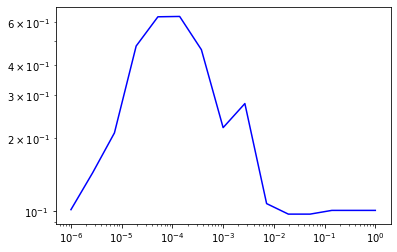

In [423]:
plt.loglog(rates,accur,'b-')

In [424]:
[(x[0],x[1]) for x in list(zip(rates,accur)) if x[1] == np.max(accur)]

[(0.00013894954943731373, 0.6335999965667725)]

So we found out best `lr` is `0.00013894954943731373`. take an order less.

In [425]:
deeper_net = nn.Sequential(
                nn.Linear(image_size,200),
                nn.ReLU(),
                #nn.Linear(200,50),
                #nn.LogSoftmax(dim=1),
                nn.Linear(200,20),
                nn.ReLU(),
                nn.Linear(20,len(numbers))) # since we have 10 categories as output
loss = nn.CrossEntropyLoss() # loss for multicategories
dls,train_dset,test_dset = make_dls(train_x_stack,train_y_stack,test_x_stack,test_y_stack,bs)
#take one order less than where minimum was acheived. avoid overfit.
# lets try without that
learn = Learner(dls, model=deeper_net, lr = 0.000139, loss_func = loss, metrics= accuracy)
learn.fit(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.377170,2.242231,0.227400,00:01
1,2.187457,2.074836,0.245600,00:01
2,2.032747,1.836355,0.378800,00:01
3,1.820405,1.628841,0.435300,00:01
4,1.635683,1.458519,0.474900,00:01
5,1.488029,1.313945,0.524900,00:01
6,1.370814,1.189013,0.583800,00:01
7,1.258433,1.096522,0.597900,00:01
8,1.167311,1.018200,0.613400,00:01
9,1.088220,0.950550,0.634200,00:01


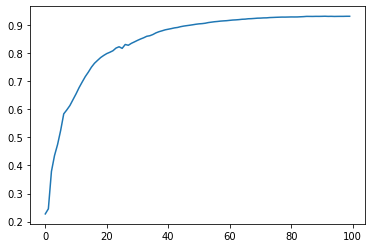

In [427]:
plt.plot(L(learn.recorder.values).itemgot(2))

# LR Finder fastai

In [489]:
deeper_net = nn.Sequential(
                nn.Linear(image_size,200),
                nn.ReLU(),
                #nn.Linear(200,50),
                #nn.LogSoftmax(dim=1),
                nn.Linear(200,20),
                nn.ReLU(),
                nn.Linear(20,len(numbers))) # since we have 10 categories as output
loss = nn.CrossEntropyLoss() # loss for multicategories
dls,train_dset,test_dset = make_dls(train_x_stack,train_y_stack,test_x_stack,test_y_stack,bs)

learn = Learner(dls, model=deeper_net, loss_func = loss, metrics= accuracy) # dont provide, fastai defaults to 0.001

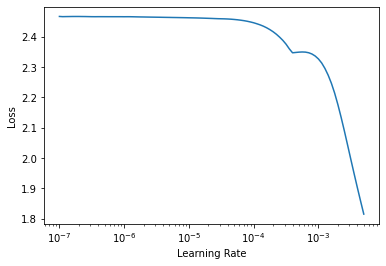

In [490]:
lr_min,lr_steep = learn.lr_find(start_lr=1e-7, end_lr=1e-2, show_plot=True,suggestions=True)

**Divides automatically by 10 I think in plot**

In [491]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.01e-04, steepest point: 2.82e-03


In fact, same as the manual approach, but here its plotting loss and lr. Much useful to understand the landscape. 

But the steepest point could be much lower as well. 

Maybe the new lr should be around `2.82e-04`.

In [499]:
deeper_net = nn.Sequential(
                nn.Linear(image_size,200),
                nn.ReLU(),
                #nn.Linear(200,50),
                #nn.LogSoftmax(dim=1),
                nn.Linear(200,20),
                nn.ReLU(),
                nn.Linear(20,len(numbers))) # since we have 10 categories as output
loss = nn.CrossEntropyLoss() # loss for multicategories
dls,train_dset,test_dset = make_dls(train_x_stack,train_y_stack,test_x_stack,test_y_stack,bs)
learn = Learner(dls, model=deeper_net, loss_func = loss, metrics= accuracy,lr=3e-04) 
learn.fit(100)
# learn.fine_tune(100,base_lr=4e-03) # for inference

epoch,train_loss,valid_loss,accuracy,time
0,2.241384,2.622345,0.097400,00:01
1,2.083688,2.736285,0.097600,00:01
2,1.906386,2.862782,0.126200,00:01
3,1.738931,3.112877,0.212700,00:01
4,1.415130,2.951914,0.276100,00:01
5,1.129308,2.940323,0.303700,00:01
6,0.905360,2.890108,0.330700,00:01
7,0.774272,2.731993,0.365700,00:01
8,0.694481,2.658844,0.378700,00:01
9,0.625396,2.673328,0.387200,00:01


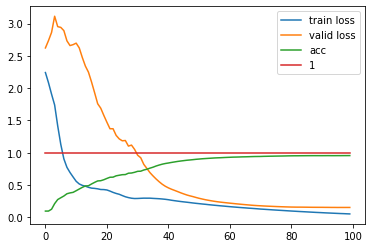

In [516]:
plt.plot(L(learn.recorder.values).itemgot(0), label='train loss')
plt.plot(L(learn.recorder.values).itemgot(1), label='valid loss')
plt.plot(L(learn.recorder.values).itemgot(2),label='acc')
plt.plot([1]*100,label='1')
plt.legend()

Went from 93% to 95% accurate model.